# 2IIG0: Data Mining and Machine Learning

### HW 3 - Group 21

Riva Mendoza 1517635 <br>
Adrian Vramulet 1284487 <br>
Joe Yu 1520466 <br>

## Part 1: MLP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from math import log2
from numpy import random as rnd
import seaborn as sns

### Prepare and Normalise Data

In [2]:
def prepareData():
    trainingData = []
    validationData = []
    
    trainFile = pd.read_excel("HW3train.xlsx")
    validateFile = pd.read_excel("HW3validate.xlsx")

    min_max_scaler = preprocessing.MinMaxScaler()
    
    trainScaled = min_max_scaler.fit_transform(trainFile.values)
    validateScaled = min_max_scaler.fit_transform(validateFile.values)
    
    for row in trainScaled:
        if int(row[2]) == 0:
            output = [1,0]
        else:
            output = [0,1]
        trainingData.append([[row[0], row[1]], output])

    for row in validateScaled:
        if int(row[2]) == 0:
            output = [1,0]
        else:
            output = [0,1]
        validationData.append([[row[0], row[1]], output])    
    
    return trainingData, validationData

### Layer Class

In [3]:
# Create layers
class Layer:
    # Initalise layer given number of neurons, activation type, weights and bias
    def __init__(self, numNeurons, activation, weights, bias):
        self.numNeurons = numNeurons
        self.activation = activation
        self.weights = weights
        self.bias = bias
        
        self.nextWeights = weights
        self.nextBias = bias
        self.lastActivation = None
        
        self.error = None
        self.delta = None
        
    # Activates neurons by calculating dot produt
    def activate(self, input):
        x = np.dot(input, self.weights) + self.bias
        self.lastActivation = self.applyActivation(x)
        
        return self.lastActivation
    
    # Activate layer using chosen hidden layer or output layer activation function 
    def applyActivation(self, x):
        if self.activation == 'leakyReLu':
            return np.maximum(0.001*x, x)
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
    
    # Applies derivative of activation function
    def applyActivationDer(self, activation):
        if self.activation == "leakyReLu":
            der = []
            
            for x in activation:
                der.append(0.001 if x <= 0 else 1)
            
            return der
        
        elif self.activation == "sigmoid":
            return activation * (1 - activation)

### MLP Class

In [4]:
# Creates Neural Network using MLP
class MLP:
    def __init__(self):
        self.trainingErrors = []
        self.validationErrors = []
        self.layers = []
        
    # Adds layer to Neural Network
    def addLayer(self, layer):
        self.layers.append(layer)
    
    # Apply forward propagation to each layer to calculate output
    def forwardPropagate(self, input, outputHidden=False):
        hiddenOutput = []
        
        for i, layer in enumerate(self.layers):
            input = layer.activate(input)
            if outputHidden and i < len(self.layers) - 1:
                hiddenOutput.append(input)
                
        if outputHidden:
            return [item for sublist in hiddenOutput for item in sublist]
        else:
            return input
    
    # Apply back propagation to each layer and stores updates to nextWeight and nextBias
    def backPropagate(self, input, target, learningRate):
        output = self.forwardPropagate(input)

        for i in reversed(range(len(self.layers))):
            currentLayer = self.layers[i]
            
            # Apply Sigmoid to output layer
            if currentLayer == self.layers[-1]:
                currentLayer.error = target - output
                currentLayer.delta = currentLayer.error * currentLayer.applyActivationDer(output)
                
            # Apply Leaky ReLU to hidden layers
            else:
                nextLayer = self.layers[i + 1]
                currentLayer.error = np.dot(nextLayer.weights, nextLayer.delta)
                currentLayer.delta = currentLayer.error * currentLayer.applyActivationDer(currentLayer.lastActivation)
        
        # Update weights and bias
        for i in range(len(self.layers)):
            currentLayer = self.layers[i]
            
            # Input is either previous layer's activation or initial input for first hidden layer
            chosenInput = np.atleast_2d(input if i == 0 else self.layers[i-1].lastActivation)
            
            currentLayer.nextWeights += currentLayer.delta * chosenInput.T * learningRate
            currentLayer.nextBias += currentLayer.delta * learningRate
        
    # Train network using Stochastic Gradient Descent
    def trainNetwork(self, trainingData, validationData, learningRate, numEpochs, batchSize, printError=True):
        trainingErrors = []
        validationErrors = []
                
        for i in range(numEpochs):
            np.random.shuffle(trainingData)
            
            for b in range(0, len(trainingData), batchSize):
                batch = trainingData[b:min(len(trainingData), b + batchSize)]
                
                for r, row in enumerate(batch):
                    self.backPropagate(row[0], row[1], learningRate)
                    
                for layer in self.layers:
                    layer.weights = layer.nextWeights
                    layer.bias = layer.nextBias

            # Calulcate error of training and validation data
            validationErrors.append(self.calculateError(validationData))
            trainingErrors.append(self.calculateError(trainingData))
            
            # Print error and accuracy every 10 epochs
            if printError and i % 10 == 0:
                print('Epoch %s, Error: %f, Accuracy: %.6f%c' % (i, float(trainingErrors[-1]), self.calculateAccuracy(validationData), chr(37)))
                            
        self.trainingErrors = trainingErrors
        self.validationErrors = validationErrors
                    
        return trainingErrors, validationErrors
    
    # Calculate error using MSE
    def calculateError(self, data):
        squared_errors = 0
        for row in data:
            input = row[0]
            target = row[1]
            output = self.forwardPropagate(input)

            squared_errors += (target[0] - output[0]) ** 2 + (target[1] - output[1]) ** 2
        return squared_errors / len(data)
        
    # Plot errors against epoch
    def plotErrors(self, part2=False):
        if(part2):
            plt.ylim(0.49, 0.51)
            
        plt.plot(self.trainingErrors, color="blue", label="Training data")
        plt.plot(self.validationErrors, color="green", label="Validation data")
        
        plt.title("Error as epochs increase")
        plt.xlabel("Epoch")
        plt.ylabel("Error (using MSE)")
        plt.legend()
        plt.show()
    
    # Calculates confusion matrix and accuracy
    def calculateAccuracy(self, data, printMatrix=False):
        actual = []
        predicted = []
        
        # Calculate actual and predicted values
        for row in data:
            output = self.forwardPropagate(row[0])
            
            if output[0] > output[1]:
                actual.append(0)
            else:
                actual.append(1)
            
            predicted.append(row[1][1])

        # Calculate true/false positives/negatives
        truePos = 0 
        trueNeg = 0
        falsePos = 0
        falseNeg = 0
        
        for i in range(len(actual)):
            if(predicted[i] == 1 and actual[i] == 1):
                truePos += 1
            elif(predicted[i] == 0 and actual[i] == 1):
                falsePos += 1
            elif(predicted[i] == 1 and actual[i] == 0):
                falseNeg += 1
            elif(predicted[i] == 0 and actual[i] == 0):
                trueNeg += 1
        
        if(printMatrix):
            print("True Positives (Predicted: 0 Actual: 0): ", truePos)
            print("False Positives (Predicted: 0 Actual: 1): ", falsePos)
            print("True Negatives (Predicted: 1 Actual: 1): ", trueNeg)
            print("False Negatives (Predicted: 1 Actual: 0): ", falseNeg)
        
        # Calculate accuracy
        accuracy = (truePos + trueNeg) / len(actual) * 100
        return accuracy                

### Implementation

Epoch 0, Error: 0.548930, Accuracy: 68.292683%
Epoch 10, Error: 0.222527, Accuracy: 92.682927%
Epoch 20, Error: 0.159735, Accuracy: 91.463415%
Epoch 30, Error: 0.133651, Accuracy: 90.243902%
Epoch 40, Error: 0.106847, Accuracy: 93.902439%
Epoch 50, Error: 0.099112, Accuracy: 93.902439%
Epoch 60, Error: 0.081391, Accuracy: 96.341463%
Epoch 70, Error: 0.071607, Accuracy: 96.341463%
Epoch 80, Error: 0.064820, Accuracy: 97.560976%
Epoch 90, Error: 0.061054, Accuracy: 97.560976%
Epoch 100, Error: 0.056805, Accuracy: 96.341463%
Epoch 110, Error: 0.054621, Accuracy: 97.560976%
Epoch 120, Error: 0.053354, Accuracy: 97.560976%
Epoch 130, Error: 0.052246, Accuracy: 97.560976%
Epoch 140, Error: 0.051675, Accuracy: 97.560976%
Epoch 150, Error: 0.050879, Accuracy: 97.560976%
Epoch 160, Error: 0.050472, Accuracy: 97.560976%
Epoch 170, Error: 0.050066, Accuracy: 97.560976%
Epoch 180, Error: 0.049771, Accuracy: 97.560976%
Epoch 190, Error: 0.049550, Accuracy: 97.560976%


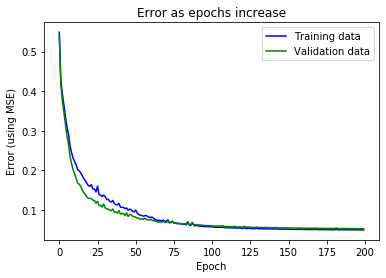

True Positives (Predicted: 0 Actual: 0):  40
False Positives (Predicted: 0 Actual: 1):  1
True Negatives (Predicted: 1 Actual: 1):  40
False Negatives (Predicted: 1 Actual: 0):  1


[[[0.6829101813151086, 0.7959072514763725], [1, 0]],
 [[0.6894429562786054, 0.3944220048201984], [0, 1]],
 [[0.05303000617239043, 0.6209571167772334], [0, 1]],
 [[0.9179460853761011, 0.7532421570009206], [1, 0]],
 [[0.3686785468096238, 0.07453665656103492], [1, 0]],
 [[0.7598666201118479, 0.06923506594507013], [0, 1]],
 [[0.12626733295053366, 0.7554909375868718], [0, 1]],
 [[0.019613650086263916, 0.7267651776287242], [1, 0]],
 [[0.5552660173366588, 0.43298327670329084], [0, 1]],
 [[0.27328668377181503, 0.37025423945631114], [1, 0]],
 [[0.5589632124926133, 0.23941671651154678], [0, 1]],
 [[0.9197754730658836, 0.7928403177395209], [1, 0]],
 [[0.3282675937305972, 0.7347607107520621], [0, 1]],
 [[0.6979770878245345, 0.16639762433084815], [0, 1]],
 [[0.879029925601574, 0.06708606428411035], [0, 1]],
 [[0.7994199772862929, 0.017744056607246254], [0, 1]],
 [[0.2680222281390964, 0.8128098670773843], [0, 1]],
 [[0.15344985000828618, 0.858826651122619], [0, 1]],
 [[0.7694338077888868, 0.69415782

In [5]:
rnd.seed(1)
trainingData, validationData = prepareData()

network = MLP()
hiddenLayer1 = Layer(10, "leakyReLu", rnd.randn(2, 10), rnd.randn(10))
hiddenLayer2 = Layer(10, "leakyReLu", rnd.randn(10, 10), rnd.randn(10))
outputLayer = Layer(2, "sigmoid", rnd.randn(10, 2), rnd.randn(2))

network.addLayer(hiddenLayer1)
network.addLayer(hiddenLayer2)
network.addLayer(outputLayer)

numEpochs = 200
learningRate = 0.01
batchSize = round(len(trainingData) / 10)

## 3. Train network
network.trainNetwork(trainingData, validationData, learningRate, numEpochs, batchSize)

# Plot errors, confusion matrix, accuracy
network.plotErrors()
network.calculateAccuracy(validationData, printMatrix=True)
validationData

## Part 2: Hyperparameters Optimization

### 2.5: Parameter Initialisation

Epoch 0, Error: 0.500000, Accuracy: 50.000000%
Epoch 10, Error: 0.500002, Accuracy: 50.000000%
Epoch 20, Error: 0.500000, Accuracy: 50.000000%
Epoch 30, Error: 0.500000, Accuracy: 50.000000%
Epoch 40, Error: 0.500001, Accuracy: 50.000000%
Epoch 50, Error: 0.500000, Accuracy: 50.000000%
Epoch 60, Error: 0.500001, Accuracy: 50.000000%
Epoch 70, Error: 0.500000, Accuracy: 50.000000%
Epoch 80, Error: 0.500001, Accuracy: 50.000000%
Epoch 90, Error: 0.500001, Accuracy: 50.000000%
Epoch 100, Error: 0.500003, Accuracy: 50.000000%
Epoch 110, Error: 0.500001, Accuracy: 50.000000%
Epoch 120, Error: 0.500000, Accuracy: 50.000000%
Epoch 130, Error: 0.500000, Accuracy: 50.000000%
Epoch 140, Error: 0.500002, Accuracy: 50.000000%
Epoch 150, Error: 0.500001, Accuracy: 50.000000%
Epoch 160, Error: 0.500000, Accuracy: 50.000000%
Epoch 170, Error: 0.500000, Accuracy: 50.000000%
Epoch 180, Error: 0.500000, Accuracy: 50.000000%
Epoch 190, Error: 0.500000, Accuracy: 50.000000%


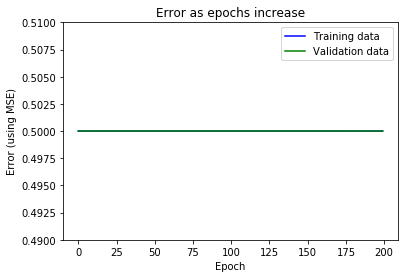

True Positives (Predicted: 0 Actual: 0):  41
False Positives (Predicted: 0 Actual: 1):  41
True Negatives (Predicted: 1 Actual: 1):  0
False Negatives (Predicted: 1 Actual: 0):  0


[[[0.6829101813151086, 0.7959072514763725], [1, 0]],
 [[0.6894429562786054, 0.3944220048201984], [0, 1]],
 [[0.05303000617239043, 0.6209571167772334], [0, 1]],
 [[0.9179460853761011, 0.7532421570009206], [1, 0]],
 [[0.3686785468096238, 0.07453665656103492], [1, 0]],
 [[0.7598666201118479, 0.06923506594507013], [0, 1]],
 [[0.12626733295053366, 0.7554909375868718], [0, 1]],
 [[0.019613650086263916, 0.7267651776287242], [1, 0]],
 [[0.5552660173366588, 0.43298327670329084], [0, 1]],
 [[0.27328668377181503, 0.37025423945631114], [1, 0]],
 [[0.5589632124926133, 0.23941671651154678], [0, 1]],
 [[0.9197754730658836, 0.7928403177395209], [1, 0]],
 [[0.3282675937305972, 0.7347607107520621], [0, 1]],
 [[0.6979770878245345, 0.16639762433084815], [0, 1]],
 [[0.879029925601574, 0.06708606428411035], [0, 1]],
 [[0.7994199772862929, 0.017744056607246254], [0, 1]],
 [[0.2680222281390964, 0.8128098670773843], [0, 1]],
 [[0.15344985000828618, 0.858826651122619], [0, 1]],
 [[0.7694338077888868, 0.69415782

In [8]:
network = MLP()
hiddenLayer1 = Layer(10, "leakyReLu", np.zeros((2,10)), np.zeros(10))
hiddenLayer2 = Layer(10, "leakyReLu", np.zeros((10,10)), np.zeros(10))
outputLayer = Layer(2, "sigmoid", np.zeros((10, 2)), np.zeros(2))

network.addLayer(hiddenLayer1)
network.addLayer(hiddenLayer2)
network.addLayer(outputLayer)

numEpochs = 200
learningRate = 0.01
batchSize = round(len(trainingData) / 10)

network.trainNetwork(trainingData, validationData, learningRate, numEpochs, batchSize)

network.plotErrors(part2=True)
network.calculateAccuracy(validationData, printMatrix=True)

### 2.6: Learning Rate vs Parameter Initialisation


Learning Rate: 0.000100, Sigma: 0.000000



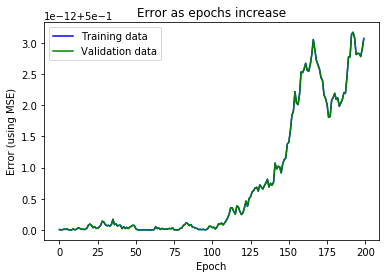

True Positives (Predicted: 0 Actual: 0):  0
False Positives (Predicted: 0 Actual: 1):  0
True Negatives (Predicted: 1 Actual: 1):  41
False Negatives (Predicted: 1 Actual: 0):  41
Accuracy: 50.000000%

Learning Rate: 0.000100, Sigma: 0.100000



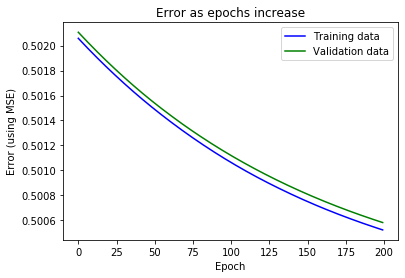

True Positives (Predicted: 0 Actual: 0):  41
False Positives (Predicted: 0 Actual: 1):  41
True Negatives (Predicted: 1 Actual: 1):  0
False Negatives (Predicted: 1 Actual: 0):  0
Accuracy: 50.000000%

Learning Rate: 0.000100, Sigma: 0.200000



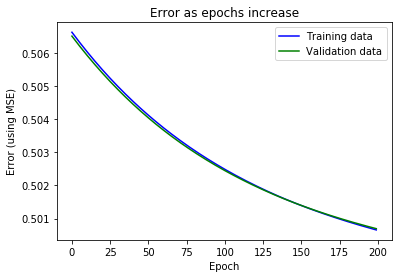

True Positives (Predicted: 0 Actual: 0):  0
False Positives (Predicted: 0 Actual: 1):  0
True Negatives (Predicted: 1 Actual: 1):  41
False Negatives (Predicted: 1 Actual: 0):  41
Accuracy: 50.000000%

Learning Rate: 0.000100, Sigma: 0.300000



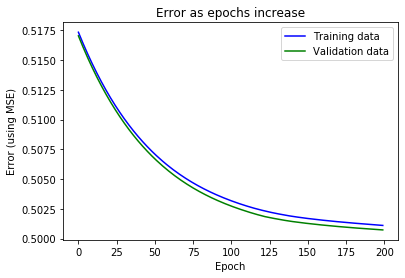

True Positives (Predicted: 0 Actual: 0):  30
False Positives (Predicted: 0 Actual: 1):  23
True Negatives (Predicted: 1 Actual: 1):  18
False Negatives (Predicted: 1 Actual: 0):  11
Accuracy: 58.536585%

Learning Rate: 0.000100, Sigma: 0.400000



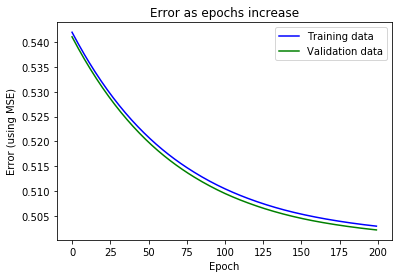

True Positives (Predicted: 0 Actual: 0):  0
False Positives (Predicted: 0 Actual: 1):  2
True Negatives (Predicted: 1 Actual: 1):  39
False Negatives (Predicted: 1 Actual: 0):  41
Accuracy: 47.560976%

Learning Rate: 0.000100, Sigma: 0.500000



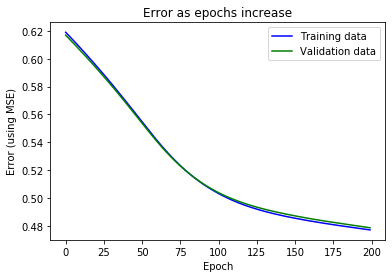

True Positives (Predicted: 0 Actual: 0):  10
False Positives (Predicted: 0 Actual: 1):  1
True Negatives (Predicted: 1 Actual: 1):  40
False Negatives (Predicted: 1 Actual: 0):  31
Accuracy: 60.975610%

Learning Rate: 0.000100, Sigma: 0.600000



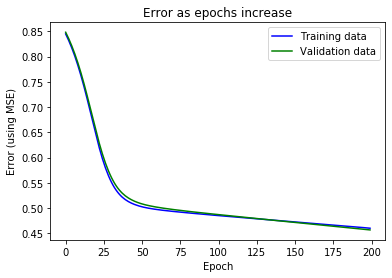

True Positives (Predicted: 0 Actual: 0):  24
False Positives (Predicted: 0 Actual: 1):  21
True Negatives (Predicted: 1 Actual: 1):  20
False Negatives (Predicted: 1 Actual: 0):  17
Accuracy: 53.658537%

Learning Rate: 0.000100, Sigma: 0.700000



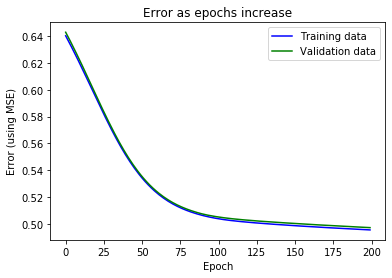

True Positives (Predicted: 0 Actual: 0):  25
False Positives (Predicted: 0 Actual: 1):  21
True Negatives (Predicted: 1 Actual: 1):  20
False Negatives (Predicted: 1 Actual: 0):  16
Accuracy: 54.878049%

Learning Rate: 0.000100, Sigma: 0.800000



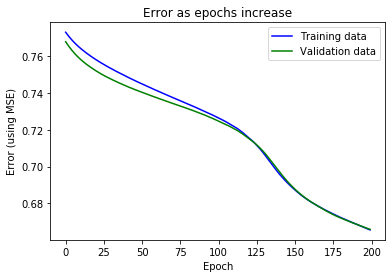

True Positives (Predicted: 0 Actual: 0):  41
False Positives (Predicted: 0 Actual: 1):  41
True Negatives (Predicted: 1 Actual: 1):  0
False Negatives (Predicted: 1 Actual: 0):  0
Accuracy: 50.000000%

Learning Rate: 0.000100, Sigma: 0.900000



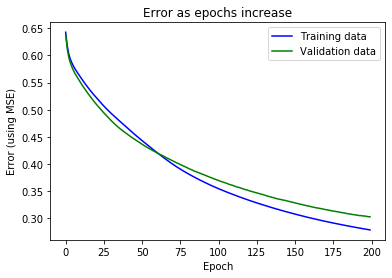

True Positives (Predicted: 0 Actual: 0):  28
False Positives (Predicted: 0 Actual: 1):  5
True Negatives (Predicted: 1 Actual: 1):  36
False Negatives (Predicted: 1 Actual: 0):  13
Accuracy: 78.048780%

Learning Rate: 0.000100, Sigma: 1.000000



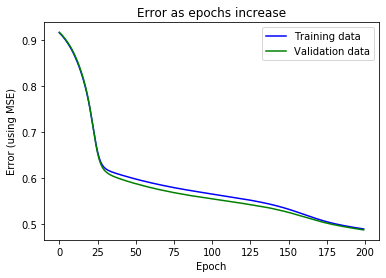

True Positives (Predicted: 0 Actual: 0):  37
False Positives (Predicted: 0 Actual: 1):  21
True Negatives (Predicted: 1 Actual: 1):  20
False Negatives (Predicted: 1 Actual: 0):  4
Accuracy: 69.512195%

Learning Rate: 0.001000, Sigma: 0.000000



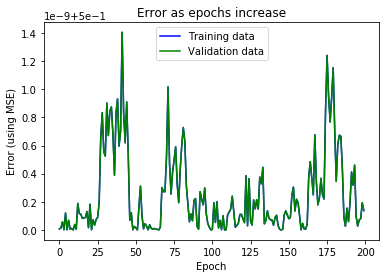

True Positives (Predicted: 0 Actual: 0):  0
False Positives (Predicted: 0 Actual: 1):  0
True Negatives (Predicted: 1 Actual: 1):  41
False Negatives (Predicted: 1 Actual: 0):  41
Accuracy: 50.000000%

Learning Rate: 0.001000, Sigma: 0.100000



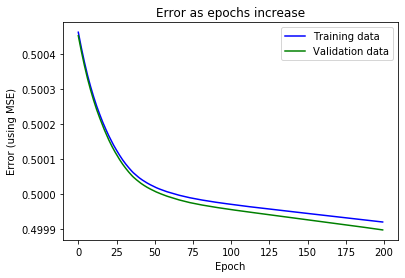

True Positives (Predicted: 0 Actual: 0):  11
False Positives (Predicted: 0 Actual: 1):  1
True Negatives (Predicted: 1 Actual: 1):  40
False Negatives (Predicted: 1 Actual: 0):  30
Accuracy: 62.195122%

Learning Rate: 0.001000, Sigma: 0.200000



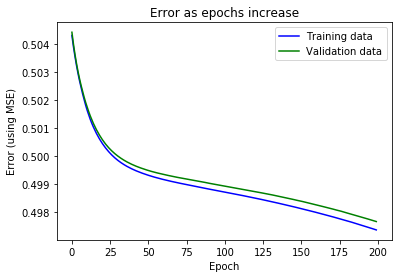

True Positives (Predicted: 0 Actual: 0):  20
False Positives (Predicted: 0 Actual: 1):  16
True Negatives (Predicted: 1 Actual: 1):  25
False Negatives (Predicted: 1 Actual: 0):  21
Accuracy: 54.878049%

Learning Rate: 0.001000, Sigma: 0.300000



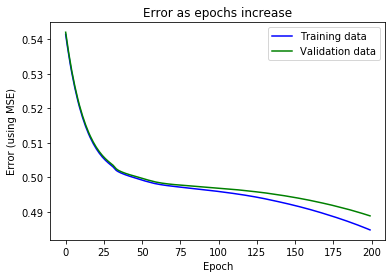

True Positives (Predicted: 0 Actual: 0):  18
False Positives (Predicted: 0 Actual: 1):  11
True Negatives (Predicted: 1 Actual: 1):  30
False Negatives (Predicted: 1 Actual: 0):  23
Accuracy: 58.536585%

Learning Rate: 0.001000, Sigma: 0.400000



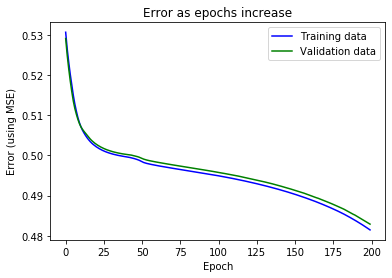

True Positives (Predicted: 0 Actual: 0):  20
False Positives (Predicted: 0 Actual: 1):  6
True Negatives (Predicted: 1 Actual: 1):  35
False Negatives (Predicted: 1 Actual: 0):  21
Accuracy: 67.073171%

Learning Rate: 0.001000, Sigma: 0.500000



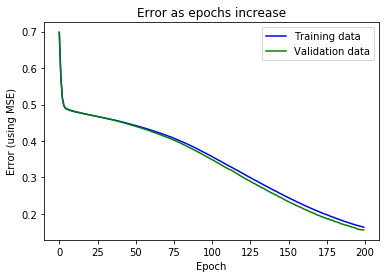

True Positives (Predicted: 0 Actual: 0):  40
False Positives (Predicted: 0 Actual: 1):  1
True Negatives (Predicted: 1 Actual: 1):  40
False Negatives (Predicted: 1 Actual: 0):  1
Accuracy: 97.560976%

Learning Rate: 0.001000, Sigma: 0.600000



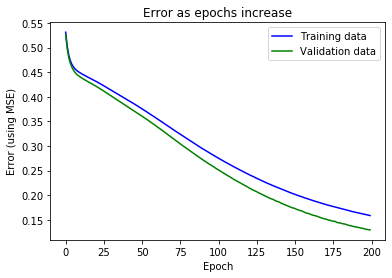

True Positives (Predicted: 0 Actual: 0):  38
False Positives (Predicted: 0 Actual: 1):  3
True Negatives (Predicted: 1 Actual: 1):  38
False Negatives (Predicted: 1 Actual: 0):  3
Accuracy: 92.682927%

Learning Rate: 0.001000, Sigma: 0.700000



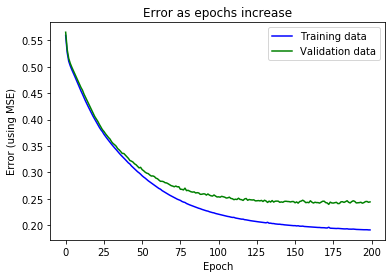

True Positives (Predicted: 0 Actual: 0):  29
False Positives (Predicted: 0 Actual: 1):  5
True Negatives (Predicted: 1 Actual: 1):  36
False Negatives (Predicted: 1 Actual: 0):  12
Accuracy: 79.268293%

Learning Rate: 0.001000, Sigma: 0.800000



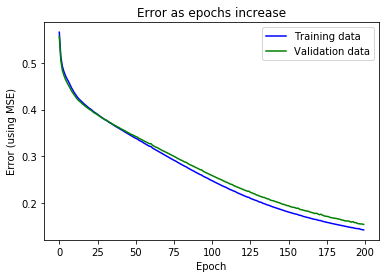

True Positives (Predicted: 0 Actual: 0):  39
False Positives (Predicted: 0 Actual: 1):  1
True Negatives (Predicted: 1 Actual: 1):  40
False Negatives (Predicted: 1 Actual: 0):  2
Accuracy: 96.341463%

Learning Rate: 0.001000, Sigma: 0.900000



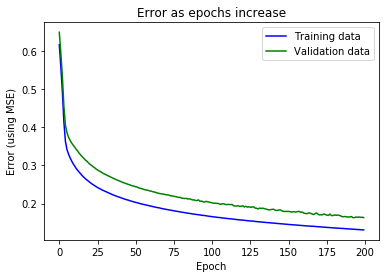

True Positives (Predicted: 0 Actual: 0):  36
False Positives (Predicted: 0 Actual: 1):  2
True Negatives (Predicted: 1 Actual: 1):  39
False Negatives (Predicted: 1 Actual: 0):  5
Accuracy: 91.463415%

Learning Rate: 0.001000, Sigma: 1.000000



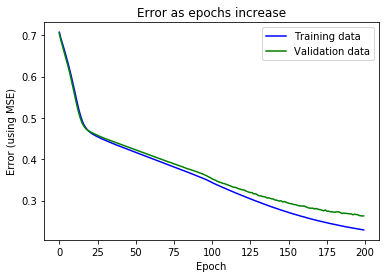

True Positives (Predicted: 0 Actual: 0):  29
False Positives (Predicted: 0 Actual: 1):  5
True Negatives (Predicted: 1 Actual: 1):  36
False Negatives (Predicted: 1 Actual: 0):  12
Accuracy: 79.268293%

Learning Rate: 0.010000, Sigma: 0.000000



KeyboardInterrupt: 

In [7]:
numEpochs = 200
learningRates = [0.0001, 0.001, 0.01, 0.1, 1]
sigmas = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1] 
batchSize = round(len(trainingData) / 10)
accuracies = []
results = []

for learningRate in learningRates:
    for sigma in sigmas:
        print("\nLearning Rate: %f, Sigma: %f\n" % (learningRate, sigma))
        network = MLP()
        hiddenLayer1 = Layer(10, "leakyReLu", sigma * rnd.randn(2, 10), sigma * rnd.randn(10))
        hiddenLayer2 = Layer(10, "leakyReLu", sigma * rnd.randn(10, 10), sigma * rnd.randn(10))
        outputLayer = Layer(2, "sigmoid", sigma * rnd.randn(10, 2), sigma * rnd.randn(2))

        network.addLayer(hiddenLayer1)
        network.addLayer(hiddenLayer2)
        network.addLayer(outputLayer)

        network.trainNetwork(trainingData, validationData, learningRate, numEpochs, batchSize, printError=False)
        network.plotErrors()
        
        accuracies.append(network.calculateAccuracy(validationData, printMatrix=True))
        print("Accuracy: %.6f%c" %(accuracies[-1], chr(37)))
        
        results.append((sigma, learningRate, accuracies[-1]))

In [ ]:
resultsToDF = pd.DataFrame(results, columns=['Sigma Squared', 'Learning Rate', 'Accuracy'])
heatmapData = pd.pivot_table(resultsToDF, values='Accuracy', index=['Learning Rate'], columns='Sigma Squared')
sns.heatmap(heatmapData, xticklabels=np.arange(0, 11)/10, annot=True, cmap="Greens", vmin=0, vmax=100)

In [72]:
numEpochs = 1
#0.001, 0.01, worst and best
#.2, .3, worst and best
learningRates = [0.001]
sigmas = [.2] 
batchSize = round(len(trainingData) / 10)
activations = []
results = []

for learningRate in learningRates:
    for sigma in sigmas:
        #print("\nLearning Rate: %f, Sigma: %f\n" % (learningRate, sigma))
        network = MLP()
        hiddenLayer1 = Layer(10, "leakyReLu", sigma * rnd.randn(2, 10), sigma * rnd.randn(10))
        hiddenLayer2 = Layer(10, "leakyReLu", sigma * rnd.randn(10, 10), sigma * rnd.randn(10))
        outputLayer = Layer(2, "sigmoid", sigma * rnd.randn(10, 2), sigma * rnd.randn(2))

        network.addLayer(hiddenLayer1)
        network.addLayer(hiddenLayer2)
        network.addLayer(outputLayer)

        network.trainNetwork(trainingData, validationData, learningRate, numEpochs, batchSize, printError=False)
        #network.plotErrors()
        #activations = np.concatenate(hiddenLayer1.lastActivation, hiddenLayer2.lastActivation)
        activations.append(hiddenLayer2.weights)
        #activations.append(network.calculateAccuracy(validationData, printMatrix=True))
        #activations.append(network.calculateAccuracy(validationData, printMatrix=True))
        
        #print("Accuracy: %.6f%c" %(accuracies[-1], chr(37)))
        
        #results.append((activations, dataID, hiddenNeuronID[-1]))
activations

[array([[-0.37113652, -0.10803352,  0.25251479,  0.34833855,  0.01029188,
         -0.16367583,  0.14104526,  0.0185732 , -0.19105184,  0.10986989],
        [-0.08533211, -0.1140268 , -0.02127274,  0.10878839, -0.13907652,
          0.00074823, -0.02471827,  0.14268243, -0.20291984, -0.1061836 ],
        [ 0.00241399, -0.020502  ,  0.06565322,  0.13050056,  0.12356371,
          0.01442775,  0.04255639, -0.33601048,  0.17070905,  0.24055629],
        [ 0.0775545 ,  0.38717329, -0.20169876,  0.13886963,  0.15871382,
          0.13300219,  0.06394323, -0.16648239,  0.28715359,  0.44434261],
        [ 0.44916443,  0.13962631,  0.09858081,  0.08274227,  0.16978613,
         -0.39242205,  0.01979716,  0.09655088, -0.11242393,  0.20675222],
        [-0.18132778,  0.21074442, -0.14832659, -0.32493122, -0.01679454,
         -0.22940837,  0.24289147,  0.18938471, -0.27254597,  0.03256521],
        [ 0.0317789 , -0.28562818,  0.48560161,  0.31448851,  0.04541961,
         -0.02562978,  0.2717671

In [ ]:
resultsToDF_2 = pd.DataFrame(results, columns=['hiddenNeuronID', 'dataID', 'activations'])
heatmapData_2 = pd.pivot_table(resultsToDF, values='activations', index=['dataID'], columns='hiddenNeuronID')
sns.heatmap(heatmapData, xticklabels=np.arange(0, 11)/10, annot=True, cmap="Greens", vmin=0, vmax=5)

In [68]:
hiddenLayer1.lastActivation

array([-2.33742178e-05,  1.04381205e-01,  9.59569416e-02, -3.24783809e-04,
        2.63580899e-01, -3.83034656e-05, -1.42964210e-05,  9.22571496e-01,
        1.27182354e-01, -7.81369650e-04])